In [2]:

from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np



Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [5]:

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.700181, acc.: 39.06%] [G loss: 0.468828]


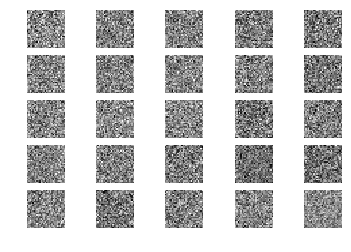

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.448294, acc.: 64.06%] [G loss: 0.433873]
2 [D loss: 0.398163, acc.: 68.75%] [G loss: 0.456640]
3 [D loss: 0.395022, acc.: 57.81%] [G loss: 0.533851]
4 [D loss: 0.367455, acc.: 75.00%] [G loss: 0.628322]
5 [D loss: 0.341067, acc.: 82.81%] [G loss: 0.730288]
6 [D loss: 0.312550, acc.: 93.75%] [G loss: 0.856270]
7 [D loss: 0.288487, acc.: 93.75%] [G loss: 1.038462]
8 [D loss: 0.237576, acc.: 95.31%] [G loss: 1.148083]
9 [D loss: 0.210621, acc.: 96.88%] [G loss: 1.348954]
10 [D loss: 0.181049, acc.: 100.00%] [G loss: 1.480507]
11 [D loss: 0.158439, acc.: 98.44%] [G loss: 1.680947]
12 [D loss: 0.155118, acc.: 98.44%] [G loss: 1.776104]
13 [D loss: 0.128286, acc.: 100.00%] [G loss: 1.988124]
14 [D loss: 0.101224, acc.: 100.00%] [G loss: 2.070065]
15 [D loss: 0.117963, acc.: 98.44%] [G loss: 2.142709]
16 [D loss: 0.082781, acc.: 100.00%] [G loss: 2.347017]
17 [D loss: 0.108947, acc.: 98.44%] [G loss: 2.266856]
18 [D loss: 0.068128, acc.: 100.00%] [G loss: 2.461617]
19 [D loss: 0.

150 [D loss: 0.193028, acc.: 93.75%] [G loss: 3.270253]
151 [D loss: 0.240851, acc.: 87.50%] [G loss: 3.692992]
152 [D loss: 0.154638, acc.: 95.31%] [G loss: 3.326725]
153 [D loss: 0.138511, acc.: 96.88%] [G loss: 3.424207]
154 [D loss: 0.348103, acc.: 82.81%] [G loss: 3.651062]
155 [D loss: 0.204475, acc.: 95.31%] [G loss: 3.433993]
156 [D loss: 0.113336, acc.: 98.44%] [G loss: 3.087191]
157 [D loss: 0.133272, acc.: 96.88%] [G loss: 3.424599]
158 [D loss: 0.235179, acc.: 95.31%] [G loss: 3.423362]
159 [D loss: 0.270518, acc.: 87.50%] [G loss: 3.926054]
160 [D loss: 0.218078, acc.: 93.75%] [G loss: 3.799983]
161 [D loss: 0.454684, acc.: 79.69%] [G loss: 3.276139]
162 [D loss: 0.198577, acc.: 93.75%] [G loss: 3.161598]
163 [D loss: 0.370169, acc.: 81.25%] [G loss: 3.234727]
164 [D loss: 0.201997, acc.: 93.75%] [G loss: 3.512754]
165 [D loss: 0.173985, acc.: 98.44%] [G loss: 3.888113]
166 [D loss: 0.114582, acc.: 100.00%] [G loss: 3.562318]
167 [D loss: 0.386401, acc.: 81.25%] [G loss: 2

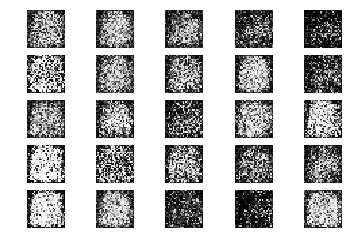

201 [D loss: 0.492893, acc.: 75.00%] [G loss: 3.032317]
202 [D loss: 0.668374, acc.: 67.19%] [G loss: 2.376280]
203 [D loss: 0.806899, acc.: 57.81%] [G loss: 2.604946]
204 [D loss: 0.428140, acc.: 78.12%] [G loss: 2.848920]
205 [D loss: 0.353628, acc.: 87.50%] [G loss: 2.732065]
206 [D loss: 0.431629, acc.: 81.25%] [G loss: 2.548925]
207 [D loss: 0.396765, acc.: 85.94%] [G loss: 3.405294]
208 [D loss: 0.476144, acc.: 84.38%] [G loss: 2.976506]
209 [D loss: 0.442440, acc.: 84.38%] [G loss: 2.508413]
210 [D loss: 0.283662, acc.: 89.06%] [G loss: 2.863510]
211 [D loss: 0.367391, acc.: 92.19%] [G loss: 2.615349]
212 [D loss: 0.255781, acc.: 93.75%] [G loss: 2.705010]
213 [D loss: 0.376680, acc.: 84.38%] [G loss: 2.643262]
214 [D loss: 0.472411, acc.: 73.44%] [G loss: 2.494941]
215 [D loss: 0.438219, acc.: 89.06%] [G loss: 3.161700]
216 [D loss: 0.426285, acc.: 89.06%] [G loss: 2.477907]
217 [D loss: 0.629899, acc.: 71.88%] [G loss: 2.064137]
218 [D loss: 0.310726, acc.: 90.62%] [G loss: 2.

350 [D loss: 0.633415, acc.: 62.50%] [G loss: 0.946585]
351 [D loss: 0.665534, acc.: 67.19%] [G loss: 1.007072]
352 [D loss: 0.710895, acc.: 48.44%] [G loss: 0.917862]
353 [D loss: 0.649163, acc.: 57.81%] [G loss: 0.924082]
354 [D loss: 0.597727, acc.: 73.44%] [G loss: 0.987627]
355 [D loss: 0.650771, acc.: 60.94%] [G loss: 0.987771]
356 [D loss: 0.667189, acc.: 57.81%] [G loss: 1.068948]
357 [D loss: 0.654364, acc.: 62.50%] [G loss: 1.064652]
358 [D loss: 0.751045, acc.: 42.19%] [G loss: 0.919326]
359 [D loss: 0.670639, acc.: 60.94%] [G loss: 0.909483]
360 [D loss: 0.588307, acc.: 70.31%] [G loss: 0.916748]
361 [D loss: 0.631084, acc.: 68.75%] [G loss: 0.917394]
362 [D loss: 0.628821, acc.: 65.62%] [G loss: 0.982459]
363 [D loss: 0.625547, acc.: 60.94%] [G loss: 1.006732]
364 [D loss: 0.599863, acc.: 65.62%] [G loss: 1.044050]
365 [D loss: 0.737946, acc.: 50.00%] [G loss: 0.943202]
366 [D loss: 0.657592, acc.: 51.56%] [G loss: 0.954506]
367 [D loss: 0.673511, acc.: 65.62%] [G loss: 0.

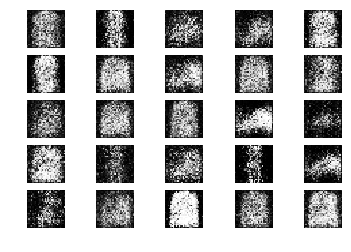

401 [D loss: 0.667570, acc.: 67.19%] [G loss: 0.941023]
402 [D loss: 0.599154, acc.: 64.06%] [G loss: 0.977771]
403 [D loss: 0.615408, acc.: 67.19%] [G loss: 0.983431]
404 [D loss: 0.607123, acc.: 65.62%] [G loss: 0.956836]
405 [D loss: 0.650707, acc.: 59.38%] [G loss: 0.912242]
406 [D loss: 0.706328, acc.: 57.81%] [G loss: 0.931069]
407 [D loss: 0.624319, acc.: 60.94%] [G loss: 1.030634]
408 [D loss: 0.624994, acc.: 65.62%] [G loss: 0.981597]
409 [D loss: 0.641045, acc.: 64.06%] [G loss: 0.858611]
410 [D loss: 0.545972, acc.: 67.19%] [G loss: 1.014356]
411 [D loss: 0.530099, acc.: 78.12%] [G loss: 0.984946]
412 [D loss: 0.539605, acc.: 79.69%] [G loss: 0.953210]
413 [D loss: 0.572450, acc.: 70.31%] [G loss: 0.998446]
414 [D loss: 0.579658, acc.: 71.88%] [G loss: 0.990518]
415 [D loss: 0.631342, acc.: 68.75%] [G loss: 0.989216]
416 [D loss: 0.673561, acc.: 57.81%] [G loss: 0.960285]
417 [D loss: 0.662453, acc.: 60.94%] [G loss: 0.982070]
418 [D loss: 0.704166, acc.: 56.25%] [G loss: 0.

552 [D loss: 0.622509, acc.: 68.75%] [G loss: 0.955368]
553 [D loss: 0.665096, acc.: 54.69%] [G loss: 0.898352]
554 [D loss: 0.707717, acc.: 57.81%] [G loss: 0.881581]
555 [D loss: 0.673027, acc.: 56.25%] [G loss: 0.811509]
556 [D loss: 0.626988, acc.: 62.50%] [G loss: 0.866347]
557 [D loss: 0.622834, acc.: 64.06%] [G loss: 0.906815]
558 [D loss: 0.645028, acc.: 57.81%] [G loss: 0.811677]
559 [D loss: 0.610263, acc.: 70.31%] [G loss: 0.841030]
560 [D loss: 0.628765, acc.: 68.75%] [G loss: 0.921297]
561 [D loss: 0.582364, acc.: 70.31%] [G loss: 0.949309]
562 [D loss: 0.633237, acc.: 62.50%] [G loss: 0.976772]
563 [D loss: 0.690081, acc.: 56.25%] [G loss: 0.937102]
564 [D loss: 0.598434, acc.: 71.88%] [G loss: 0.980598]
565 [D loss: 0.640102, acc.: 60.94%] [G loss: 0.964830]
566 [D loss: 0.635607, acc.: 59.38%] [G loss: 0.839821]
567 [D loss: 0.671205, acc.: 54.69%] [G loss: 0.910110]
568 [D loss: 0.666628, acc.: 59.38%] [G loss: 0.851094]
569 [D loss: 0.706995, acc.: 48.44%] [G loss: 0.

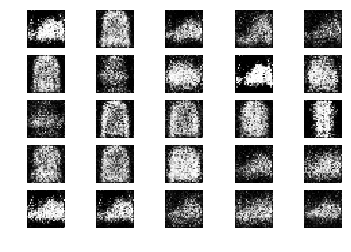

601 [D loss: 0.595834, acc.: 73.44%] [G loss: 0.900774]
602 [D loss: 0.581205, acc.: 73.44%] [G loss: 0.974408]
603 [D loss: 0.642387, acc.: 60.94%] [G loss: 0.888829]
604 [D loss: 0.650064, acc.: 65.62%] [G loss: 0.913478]
605 [D loss: 0.644369, acc.: 62.50%] [G loss: 0.899259]
606 [D loss: 0.655357, acc.: 57.81%] [G loss: 0.947750]
607 [D loss: 0.612577, acc.: 73.44%] [G loss: 0.933042]
608 [D loss: 0.676241, acc.: 60.94%] [G loss: 0.854432]
609 [D loss: 0.647828, acc.: 57.81%] [G loss: 0.884010]
610 [D loss: 0.604401, acc.: 62.50%] [G loss: 0.850961]
611 [D loss: 0.592303, acc.: 81.25%] [G loss: 0.869569]
612 [D loss: 0.631563, acc.: 60.94%] [G loss: 0.935867]
613 [D loss: 0.645093, acc.: 70.31%] [G loss: 0.835566]
614 [D loss: 0.591656, acc.: 67.19%] [G loss: 0.864399]
615 [D loss: 0.652859, acc.: 60.94%] [G loss: 0.913900]
616 [D loss: 0.608950, acc.: 70.31%] [G loss: 0.886721]
617 [D loss: 0.613463, acc.: 65.62%] [G loss: 0.886519]
618 [D loss: 0.665419, acc.: 54.69%] [G loss: 0.

751 [D loss: 0.664813, acc.: 60.94%] [G loss: 0.864726]
752 [D loss: 0.608183, acc.: 64.06%] [G loss: 0.890536]
753 [D loss: 0.629815, acc.: 64.06%] [G loss: 0.845891]
754 [D loss: 0.675484, acc.: 51.56%] [G loss: 0.931906]
755 [D loss: 0.639469, acc.: 60.94%] [G loss: 0.915566]
756 [D loss: 0.640401, acc.: 59.38%] [G loss: 0.803344]
757 [D loss: 0.660048, acc.: 56.25%] [G loss: 0.806694]
758 [D loss: 0.643522, acc.: 70.31%] [G loss: 0.911228]
759 [D loss: 0.704476, acc.: 51.56%] [G loss: 0.863860]
760 [D loss: 0.624720, acc.: 65.62%] [G loss: 0.858279]
761 [D loss: 0.630920, acc.: 65.62%] [G loss: 0.843388]
762 [D loss: 0.657403, acc.: 64.06%] [G loss: 0.832861]
763 [D loss: 0.683528, acc.: 64.06%] [G loss: 0.866812]
764 [D loss: 0.641621, acc.: 57.81%] [G loss: 0.851679]
765 [D loss: 0.650898, acc.: 62.50%] [G loss: 0.864246]
766 [D loss: 0.677340, acc.: 56.25%] [G loss: 0.809566]
767 [D loss: 0.624034, acc.: 68.75%] [G loss: 0.905354]
768 [D loss: 0.635911, acc.: 67.19%] [G loss: 0.

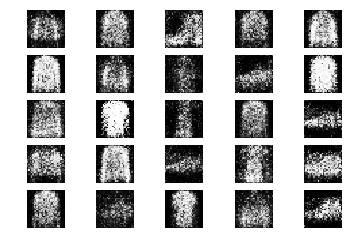

801 [D loss: 0.679724, acc.: 54.69%] [G loss: 0.871745]
802 [D loss: 0.608068, acc.: 67.19%] [G loss: 0.896776]
803 [D loss: 0.664148, acc.: 60.94%] [G loss: 0.878248]
804 [D loss: 0.640626, acc.: 62.50%] [G loss: 0.920004]
805 [D loss: 0.635854, acc.: 60.94%] [G loss: 0.902320]
806 [D loss: 0.557887, acc.: 70.31%] [G loss: 0.884733]
807 [D loss: 0.598732, acc.: 64.06%] [G loss: 0.939951]
808 [D loss: 0.581736, acc.: 68.75%] [G loss: 0.847342]
809 [D loss: 0.577076, acc.: 68.75%] [G loss: 0.849585]
810 [D loss: 0.650606, acc.: 65.62%] [G loss: 0.870587]
811 [D loss: 0.615399, acc.: 70.31%] [G loss: 0.949321]
812 [D loss: 0.667434, acc.: 64.06%] [G loss: 0.879145]
813 [D loss: 0.655365, acc.: 54.69%] [G loss: 0.889190]
814 [D loss: 0.671416, acc.: 53.12%] [G loss: 0.871852]
815 [D loss: 0.658805, acc.: 60.94%] [G loss: 0.849606]
816 [D loss: 0.596130, acc.: 70.31%] [G loss: 0.815764]
817 [D loss: 0.669528, acc.: 53.12%] [G loss: 0.798313]
818 [D loss: 0.635598, acc.: 73.44%] [G loss: 0.

950 [D loss: 0.645089, acc.: 68.75%] [G loss: 0.878355]
951 [D loss: 0.674628, acc.: 53.12%] [G loss: 0.815477]
952 [D loss: 0.627153, acc.: 68.75%] [G loss: 0.854935]
953 [D loss: 0.645255, acc.: 60.94%] [G loss: 0.797193]
954 [D loss: 0.648849, acc.: 65.62%] [G loss: 0.845670]
955 [D loss: 0.636728, acc.: 64.06%] [G loss: 0.843699]
956 [D loss: 0.615970, acc.: 67.19%] [G loss: 0.847066]
957 [D loss: 0.570667, acc.: 76.56%] [G loss: 0.870389]
958 [D loss: 0.652394, acc.: 60.94%] [G loss: 0.913412]
959 [D loss: 0.572002, acc.: 75.00%] [G loss: 0.853439]
960 [D loss: 0.678105, acc.: 57.81%] [G loss: 0.766981]
961 [D loss: 0.647620, acc.: 62.50%] [G loss: 0.891587]
962 [D loss: 0.707367, acc.: 50.00%] [G loss: 0.829338]
963 [D loss: 0.620299, acc.: 71.88%] [G loss: 0.859655]
964 [D loss: 0.618671, acc.: 65.62%] [G loss: 0.833531]
965 [D loss: 0.645270, acc.: 51.56%] [G loss: 0.897304]
966 [D loss: 0.638480, acc.: 65.62%] [G loss: 0.802112]
967 [D loss: 0.709591, acc.: 56.25%] [G loss: 0.

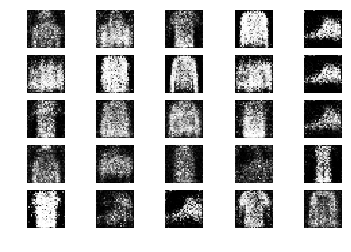

1001 [D loss: 0.673849, acc.: 60.94%] [G loss: 0.824199]
1002 [D loss: 0.599578, acc.: 71.88%] [G loss: 0.856584]
1003 [D loss: 0.602658, acc.: 71.88%] [G loss: 0.812467]
1004 [D loss: 0.728250, acc.: 57.81%] [G loss: 0.905879]
1005 [D loss: 0.613032, acc.: 70.31%] [G loss: 0.856030]
1006 [D loss: 0.653587, acc.: 62.50%] [G loss: 0.922375]
1007 [D loss: 0.637021, acc.: 68.75%] [G loss: 0.912355]
1008 [D loss: 0.643796, acc.: 62.50%] [G loss: 0.820632]
1009 [D loss: 0.684484, acc.: 54.69%] [G loss: 0.853912]
1010 [D loss: 0.592821, acc.: 67.19%] [G loss: 0.864018]
1011 [D loss: 0.606505, acc.: 70.31%] [G loss: 0.894490]
1012 [D loss: 0.646038, acc.: 64.06%] [G loss: 0.902372]
1013 [D loss: 0.738626, acc.: 45.31%] [G loss: 0.873924]
1014 [D loss: 0.664676, acc.: 62.50%] [G loss: 0.875484]
1015 [D loss: 0.616630, acc.: 68.75%] [G loss: 0.853864]
1016 [D loss: 0.651844, acc.: 67.19%] [G loss: 0.817340]
1017 [D loss: 0.612451, acc.: 67.19%] [G loss: 0.836491]
1018 [D loss: 0.625350, acc.: 6

1150 [D loss: 0.679202, acc.: 60.94%] [G loss: 0.846063]
1151 [D loss: 0.617282, acc.: 64.06%] [G loss: 0.812559]
1152 [D loss: 0.673271, acc.: 59.38%] [G loss: 0.754108]
1153 [D loss: 0.663769, acc.: 57.81%] [G loss: 0.810589]
1154 [D loss: 0.661510, acc.: 53.12%] [G loss: 0.834248]
1155 [D loss: 0.611912, acc.: 70.31%] [G loss: 0.816418]
1156 [D loss: 0.598593, acc.: 67.19%] [G loss: 0.861312]
1157 [D loss: 0.655008, acc.: 60.94%] [G loss: 0.901482]
1158 [D loss: 0.635915, acc.: 73.44%] [G loss: 0.911470]
1159 [D loss: 0.645993, acc.: 64.06%] [G loss: 0.798333]
1160 [D loss: 0.670073, acc.: 60.94%] [G loss: 0.847130]
1161 [D loss: 0.709462, acc.: 56.25%] [G loss: 0.878606]
1162 [D loss: 0.625335, acc.: 68.75%] [G loss: 0.908196]
1163 [D loss: 0.671004, acc.: 56.25%] [G loss: 0.909577]
1164 [D loss: 0.669926, acc.: 53.12%] [G loss: 0.825313]
1165 [D loss: 0.686388, acc.: 57.81%] [G loss: 0.814112]
1166 [D loss: 0.643705, acc.: 64.06%] [G loss: 0.853906]
1167 [D loss: 0.641785, acc.: 6

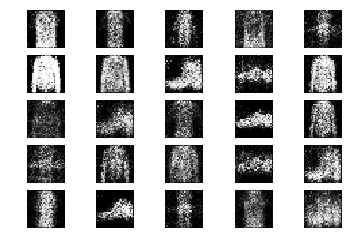

1201 [D loss: 0.634102, acc.: 62.50%] [G loss: 0.856252]
1202 [D loss: 0.612726, acc.: 65.62%] [G loss: 0.864664]
1203 [D loss: 0.635509, acc.: 68.75%] [G loss: 0.829777]
1204 [D loss: 0.644723, acc.: 57.81%] [G loss: 0.878812]
1205 [D loss: 0.654539, acc.: 59.38%] [G loss: 0.922249]
1206 [D loss: 0.567167, acc.: 75.00%] [G loss: 0.966955]
1207 [D loss: 0.628687, acc.: 73.44%] [G loss: 0.739120]
1208 [D loss: 0.648815, acc.: 64.06%] [G loss: 0.857330]
1209 [D loss: 0.669782, acc.: 57.81%] [G loss: 0.843664]
1210 [D loss: 0.667894, acc.: 54.69%] [G loss: 0.834728]
1211 [D loss: 0.605959, acc.: 73.44%] [G loss: 0.832008]
1212 [D loss: 0.709770, acc.: 54.69%] [G loss: 0.810460]
1213 [D loss: 0.609299, acc.: 67.19%] [G loss: 0.821503]
1214 [D loss: 0.614793, acc.: 65.62%] [G loss: 0.859060]
1215 [D loss: 0.603859, acc.: 68.75%] [G loss: 0.926318]
1216 [D loss: 0.720073, acc.: 50.00%] [G loss: 0.826977]
1217 [D loss: 0.638491, acc.: 59.38%] [G loss: 0.835642]
1218 [D loss: 0.637772, acc.: 5

1345 [D loss: 0.670364, acc.: 57.81%] [G loss: 0.822381]
1346 [D loss: 0.622689, acc.: 71.88%] [G loss: 0.895573]
1347 [D loss: 0.667177, acc.: 64.06%] [G loss: 0.951066]
1348 [D loss: 0.626352, acc.: 54.69%] [G loss: 0.822133]
1349 [D loss: 0.673899, acc.: 54.69%] [G loss: 0.868152]
1350 [D loss: 0.655748, acc.: 62.50%] [G loss: 0.856384]
1351 [D loss: 0.670791, acc.: 59.38%] [G loss: 0.958112]
1352 [D loss: 0.618455, acc.: 70.31%] [G loss: 0.988281]
1353 [D loss: 0.651932, acc.: 62.50%] [G loss: 0.944520]
1354 [D loss: 0.678142, acc.: 57.81%] [G loss: 0.801668]
1355 [D loss: 0.740828, acc.: 45.31%] [G loss: 0.880205]
1356 [D loss: 0.637378, acc.: 67.19%] [G loss: 0.821218]
1357 [D loss: 0.664552, acc.: 57.81%] [G loss: 0.816894]
1358 [D loss: 0.637058, acc.: 59.38%] [G loss: 0.854628]
1359 [D loss: 0.614809, acc.: 68.75%] [G loss: 0.951629]
1360 [D loss: 0.634601, acc.: 60.94%] [G loss: 0.899387]
1361 [D loss: 0.720361, acc.: 54.69%] [G loss: 0.901453]
1362 [D loss: 0.689634, acc.: 5

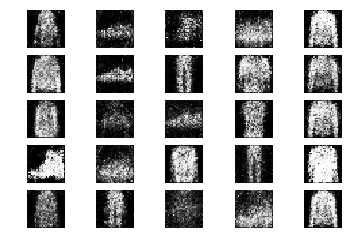

1401 [D loss: 0.617793, acc.: 62.50%] [G loss: 0.819980]
1402 [D loss: 0.755579, acc.: 50.00%] [G loss: 0.833288]
1403 [D loss: 0.603871, acc.: 75.00%] [G loss: 0.882479]
1404 [D loss: 0.709527, acc.: 54.69%] [G loss: 0.857780]
1405 [D loss: 0.706029, acc.: 57.81%] [G loss: 0.812841]
1406 [D loss: 0.709583, acc.: 48.44%] [G loss: 0.824120]
1407 [D loss: 0.577242, acc.: 70.31%] [G loss: 0.820998]
1408 [D loss: 0.664870, acc.: 59.38%] [G loss: 0.858005]
1409 [D loss: 0.599730, acc.: 68.75%] [G loss: 0.908265]
1410 [D loss: 0.590371, acc.: 67.19%] [G loss: 0.840400]
1411 [D loss: 0.690545, acc.: 51.56%] [G loss: 0.853218]
1412 [D loss: 0.625638, acc.: 56.25%] [G loss: 0.846658]
1413 [D loss: 0.648500, acc.: 51.56%] [G loss: 0.859719]
1414 [D loss: 0.600074, acc.: 71.88%] [G loss: 0.869975]
1415 [D loss: 0.681615, acc.: 54.69%] [G loss: 0.905337]
1416 [D loss: 0.661106, acc.: 59.38%] [G loss: 0.851800]
1417 [D loss: 0.700475, acc.: 46.88%] [G loss: 0.900054]
1418 [D loss: 0.638322, acc.: 6

1547 [D loss: 0.651714, acc.: 59.38%] [G loss: 0.915734]
1548 [D loss: 0.643521, acc.: 62.50%] [G loss: 0.968129]
1549 [D loss: 0.643205, acc.: 64.06%] [G loss: 1.001098]
1550 [D loss: 0.655059, acc.: 59.38%] [G loss: 0.897042]
1551 [D loss: 0.646110, acc.: 65.62%] [G loss: 0.922542]
1552 [D loss: 0.614796, acc.: 64.06%] [G loss: 0.891898]
1553 [D loss: 0.598133, acc.: 68.75%] [G loss: 0.923897]
1554 [D loss: 0.658868, acc.: 60.94%] [G loss: 0.824621]
1555 [D loss: 0.669916, acc.: 56.25%] [G loss: 0.847913]
1556 [D loss: 0.612516, acc.: 65.62%] [G loss: 0.910228]
1557 [D loss: 0.639515, acc.: 59.38%] [G loss: 0.829750]
1558 [D loss: 0.663560, acc.: 54.69%] [G loss: 0.899661]
1559 [D loss: 0.597672, acc.: 70.31%] [G loss: 0.812366]
1560 [D loss: 0.625045, acc.: 67.19%] [G loss: 0.859270]
1561 [D loss: 0.594285, acc.: 65.62%] [G loss: 0.875100]
1562 [D loss: 0.596374, acc.: 65.62%] [G loss: 0.916662]
1563 [D loss: 0.615997, acc.: 64.06%] [G loss: 0.908339]
1564 [D loss: 0.645216, acc.: 6

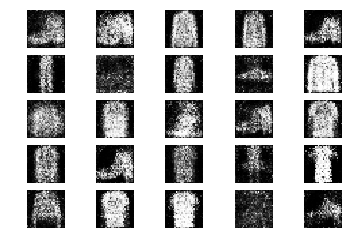

1601 [D loss: 0.643779, acc.: 67.19%] [G loss: 0.919596]
1602 [D loss: 0.648332, acc.: 57.81%] [G loss: 0.874385]
1603 [D loss: 0.660310, acc.: 57.81%] [G loss: 0.951334]
1604 [D loss: 0.629900, acc.: 64.06%] [G loss: 0.838545]
1605 [D loss: 0.615983, acc.: 67.19%] [G loss: 0.862249]
1606 [D loss: 0.588463, acc.: 75.00%] [G loss: 0.873545]
1607 [D loss: 0.612578, acc.: 68.75%] [G loss: 0.815383]
1608 [D loss: 0.693926, acc.: 56.25%] [G loss: 0.851864]
1609 [D loss: 0.642380, acc.: 65.62%] [G loss: 0.925332]
1610 [D loss: 0.642766, acc.: 62.50%] [G loss: 0.887735]
1611 [D loss: 0.669010, acc.: 56.25%] [G loss: 0.860971]
1612 [D loss: 0.622064, acc.: 67.19%] [G loss: 0.895411]
1613 [D loss: 0.637317, acc.: 62.50%] [G loss: 0.868683]
1614 [D loss: 0.629775, acc.: 60.94%] [G loss: 0.871762]
1615 [D loss: 0.594364, acc.: 75.00%] [G loss: 0.908074]
1616 [D loss: 0.614889, acc.: 62.50%] [G loss: 0.947915]
1617 [D loss: 0.644971, acc.: 70.31%] [G loss: 0.898038]
1618 [D loss: 0.649155, acc.: 6

1748 [D loss: 0.578424, acc.: 73.44%] [G loss: 0.868162]
1749 [D loss: 0.598185, acc.: 65.62%] [G loss: 0.951167]
1750 [D loss: 0.671734, acc.: 64.06%] [G loss: 0.847892]
1751 [D loss: 0.626375, acc.: 57.81%] [G loss: 0.942560]
1752 [D loss: 0.630417, acc.: 68.75%] [G loss: 0.906553]
1753 [D loss: 0.641153, acc.: 64.06%] [G loss: 0.916565]
1754 [D loss: 0.609053, acc.: 65.62%] [G loss: 0.941161]
1755 [D loss: 0.685050, acc.: 54.69%] [G loss: 0.905807]
1756 [D loss: 0.649940, acc.: 54.69%] [G loss: 0.889331]
1757 [D loss: 0.635163, acc.: 65.62%] [G loss: 0.877717]
1758 [D loss: 0.599419, acc.: 67.19%] [G loss: 0.888275]
1759 [D loss: 0.616898, acc.: 71.88%] [G loss: 0.839008]
1760 [D loss: 0.576382, acc.: 68.75%] [G loss: 0.879803]
1761 [D loss: 0.659236, acc.: 59.38%] [G loss: 0.826173]
1762 [D loss: 0.624487, acc.: 76.56%] [G loss: 0.770879]
1763 [D loss: 0.608669, acc.: 67.19%] [G loss: 0.806946]
1764 [D loss: 0.656137, acc.: 59.38%] [G loss: 0.826200]
1765 [D loss: 0.658472, acc.: 5

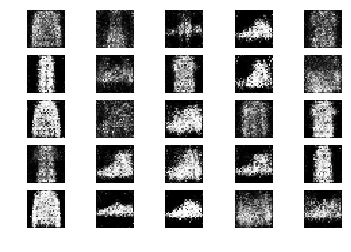

1801 [D loss: 0.620425, acc.: 64.06%] [G loss: 0.897934]
1802 [D loss: 0.612080, acc.: 64.06%] [G loss: 0.960926]
1803 [D loss: 0.652928, acc.: 56.25%] [G loss: 0.885833]
1804 [D loss: 0.621523, acc.: 64.06%] [G loss: 0.926983]
1805 [D loss: 0.587461, acc.: 75.00%] [G loss: 0.810556]
1806 [D loss: 0.598666, acc.: 70.31%] [G loss: 0.857070]
1807 [D loss: 0.625075, acc.: 68.75%] [G loss: 0.940035]
1808 [D loss: 0.612431, acc.: 71.88%] [G loss: 0.947686]
1809 [D loss: 0.599848, acc.: 70.31%] [G loss: 0.865066]
1810 [D loss: 0.641665, acc.: 68.75%] [G loss: 0.878780]
1811 [D loss: 0.676386, acc.: 51.56%] [G loss: 0.820473]
1812 [D loss: 0.598922, acc.: 75.00%] [G loss: 0.931436]
1813 [D loss: 0.617579, acc.: 68.75%] [G loss: 0.879346]
1814 [D loss: 0.649900, acc.: 60.94%] [G loss: 0.953452]
1815 [D loss: 0.615696, acc.: 71.88%] [G loss: 0.886122]
1816 [D loss: 0.635756, acc.: 62.50%] [G loss: 0.890617]
1817 [D loss: 0.642446, acc.: 60.94%] [G loss: 0.919685]
1818 [D loss: 0.630871, acc.: 6

1949 [D loss: 0.636101, acc.: 59.38%] [G loss: 0.900848]
1950 [D loss: 0.606767, acc.: 64.06%] [G loss: 0.903496]
1951 [D loss: 0.575132, acc.: 76.56%] [G loss: 0.963246]
1952 [D loss: 0.617606, acc.: 67.19%] [G loss: 0.926962]
1953 [D loss: 0.649700, acc.: 67.19%] [G loss: 0.933469]
1954 [D loss: 0.607219, acc.: 62.50%] [G loss: 0.923525]
1955 [D loss: 0.639212, acc.: 64.06%] [G loss: 0.963356]
1956 [D loss: 0.625849, acc.: 65.62%] [G loss: 0.901382]
1957 [D loss: 0.670207, acc.: 45.31%] [G loss: 0.909939]
1958 [D loss: 0.571230, acc.: 70.31%] [G loss: 0.924854]
1959 [D loss: 0.620988, acc.: 67.19%] [G loss: 0.948620]
1960 [D loss: 0.644013, acc.: 54.69%] [G loss: 0.918029]
1961 [D loss: 0.610848, acc.: 70.31%] [G loss: 0.880078]
1962 [D loss: 0.572084, acc.: 73.44%] [G loss: 0.873467]
1963 [D loss: 0.687612, acc.: 64.06%] [G loss: 0.875295]
1964 [D loss: 0.641885, acc.: 62.50%] [G loss: 0.901168]
1965 [D loss: 0.669218, acc.: 62.50%] [G loss: 0.893394]
1966 [D loss: 0.651039, acc.: 5

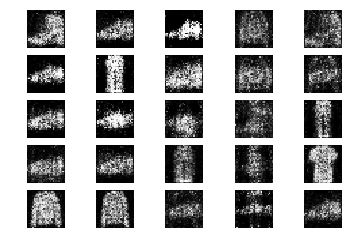

2001 [D loss: 0.620031, acc.: 70.31%] [G loss: 0.943318]
2002 [D loss: 0.633699, acc.: 70.31%] [G loss: 0.891303]
2003 [D loss: 0.642679, acc.: 65.62%] [G loss: 0.864631]
2004 [D loss: 0.612362, acc.: 68.75%] [G loss: 0.802641]
2005 [D loss: 0.619824, acc.: 62.50%] [G loss: 0.865290]
2006 [D loss: 0.584975, acc.: 70.31%] [G loss: 0.981239]
2007 [D loss: 0.587970, acc.: 70.31%] [G loss: 0.929133]
2008 [D loss: 0.662869, acc.: 57.81%] [G loss: 0.932196]
2009 [D loss: 0.624545, acc.: 60.94%] [G loss: 0.922564]
2010 [D loss: 0.607345, acc.: 59.38%] [G loss: 0.960580]
2011 [D loss: 0.597206, acc.: 73.44%] [G loss: 0.942728]
2012 [D loss: 0.580311, acc.: 70.31%] [G loss: 0.970264]
2013 [D loss: 0.673765, acc.: 56.25%] [G loss: 0.852925]
2014 [D loss: 0.635082, acc.: 65.62%] [G loss: 0.913639]
2015 [D loss: 0.580513, acc.: 71.88%] [G loss: 1.052002]
2016 [D loss: 0.668080, acc.: 59.38%] [G loss: 0.932802]
2017 [D loss: 0.586920, acc.: 65.62%] [G loss: 0.830141]
2018 [D loss: 0.640729, acc.: 6

2148 [D loss: 0.599933, acc.: 70.31%] [G loss: 0.897658]
2149 [D loss: 0.654737, acc.: 54.69%] [G loss: 0.933929]
2150 [D loss: 0.610853, acc.: 65.62%] [G loss: 0.937913]
2151 [D loss: 0.646384, acc.: 60.94%] [G loss: 0.909436]
2152 [D loss: 0.681464, acc.: 53.12%] [G loss: 0.887012]
2153 [D loss: 0.629411, acc.: 68.75%] [G loss: 0.958587]
2154 [D loss: 0.640091, acc.: 56.25%] [G loss: 0.863637]
2155 [D loss: 0.527367, acc.: 81.25%] [G loss: 0.788158]
2156 [D loss: 0.666846, acc.: 59.38%] [G loss: 0.810030]
2157 [D loss: 0.612894, acc.: 59.38%] [G loss: 0.869535]
2158 [D loss: 0.625970, acc.: 62.50%] [G loss: 0.873125]
2159 [D loss: 0.667925, acc.: 60.94%] [G loss: 0.910912]
2160 [D loss: 0.623262, acc.: 65.62%] [G loss: 0.925084]
2161 [D loss: 0.608211, acc.: 71.88%] [G loss: 0.880231]
2162 [D loss: 0.633024, acc.: 60.94%] [G loss: 0.939298]
2163 [D loss: 0.607255, acc.: 64.06%] [G loss: 0.939656]
2164 [D loss: 0.586185, acc.: 71.88%] [G loss: 0.960332]
2165 [D loss: 0.611517, acc.: 6

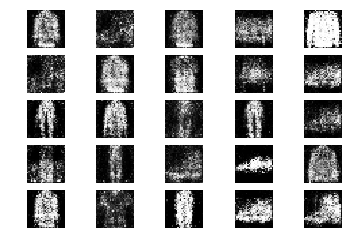

2201 [D loss: 0.593077, acc.: 67.19%] [G loss: 0.914323]
2202 [D loss: 0.588519, acc.: 71.88%] [G loss: 0.912046]
2203 [D loss: 0.616813, acc.: 68.75%] [G loss: 0.985431]
2204 [D loss: 0.644287, acc.: 59.38%] [G loss: 0.961689]
2205 [D loss: 0.629948, acc.: 70.31%] [G loss: 0.948491]
2206 [D loss: 0.681279, acc.: 53.12%] [G loss: 0.906187]
2207 [D loss: 0.602298, acc.: 65.62%] [G loss: 0.834003]
2208 [D loss: 0.676180, acc.: 60.94%] [G loss: 0.955373]
2209 [D loss: 0.624955, acc.: 59.38%] [G loss: 0.937380]
2210 [D loss: 0.628822, acc.: 60.94%] [G loss: 0.840873]
2211 [D loss: 0.662720, acc.: 57.81%] [G loss: 0.950091]
2212 [D loss: 0.626992, acc.: 59.38%] [G loss: 0.932872]
2213 [D loss: 0.608556, acc.: 68.75%] [G loss: 0.905025]
2214 [D loss: 0.632014, acc.: 64.06%] [G loss: 0.841622]
2215 [D loss: 0.636853, acc.: 65.62%] [G loss: 0.911477]
2216 [D loss: 0.615568, acc.: 57.81%] [G loss: 0.919958]
2217 [D loss: 0.639564, acc.: 65.62%] [G loss: 0.985168]
2218 [D loss: 0.617987, acc.: 7

2347 [D loss: 0.573147, acc.: 60.94%] [G loss: 0.815628]
2348 [D loss: 0.586022, acc.: 71.88%] [G loss: 0.929193]
2349 [D loss: 0.667088, acc.: 62.50%] [G loss: 0.939854]
2350 [D loss: 0.687216, acc.: 60.94%] [G loss: 0.996363]
2351 [D loss: 0.552879, acc.: 79.69%] [G loss: 0.969461]
2352 [D loss: 0.629118, acc.: 75.00%] [G loss: 0.886983]
2353 [D loss: 0.640548, acc.: 62.50%] [G loss: 0.918032]
2354 [D loss: 0.651131, acc.: 60.94%] [G loss: 0.928794]
2355 [D loss: 0.637121, acc.: 62.50%] [G loss: 0.932799]
2356 [D loss: 0.609041, acc.: 65.62%] [G loss: 0.916993]
2357 [D loss: 0.563604, acc.: 70.31%] [G loss: 0.962394]
2358 [D loss: 0.603132, acc.: 64.06%] [G loss: 1.024113]
2359 [D loss: 0.629762, acc.: 64.06%] [G loss: 1.028966]
2360 [D loss: 0.609777, acc.: 76.56%] [G loss: 0.907603]
2361 [D loss: 0.653001, acc.: 60.94%] [G loss: 0.796762]
2362 [D loss: 0.618755, acc.: 64.06%] [G loss: 0.871797]
2363 [D loss: 0.641193, acc.: 62.50%] [G loss: 0.860029]
2364 [D loss: 0.582886, acc.: 6

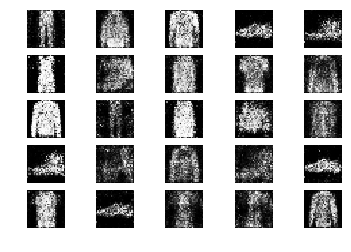

2401 [D loss: 0.652967, acc.: 64.06%] [G loss: 1.007279]
2402 [D loss: 0.640260, acc.: 64.06%] [G loss: 0.880945]
2403 [D loss: 0.643561, acc.: 56.25%] [G loss: 0.803162]
2404 [D loss: 0.623858, acc.: 65.62%] [G loss: 0.923105]
2405 [D loss: 0.609107, acc.: 60.94%] [G loss: 0.959512]
2406 [D loss: 0.706752, acc.: 60.94%] [G loss: 0.933704]
2407 [D loss: 0.654983, acc.: 56.25%] [G loss: 0.995850]
2408 [D loss: 0.685230, acc.: 56.25%] [G loss: 0.961885]
2409 [D loss: 0.614971, acc.: 67.19%] [G loss: 0.875575]
2410 [D loss: 0.605986, acc.: 71.88%] [G loss: 0.778351]
2411 [D loss: 0.571563, acc.: 76.56%] [G loss: 0.914936]
2412 [D loss: 0.628743, acc.: 62.50%] [G loss: 0.910403]
2413 [D loss: 0.689256, acc.: 54.69%] [G loss: 0.846002]
2414 [D loss: 0.626790, acc.: 57.81%] [G loss: 0.896532]
2415 [D loss: 0.614084, acc.: 65.62%] [G loss: 0.961499]
2416 [D loss: 0.618975, acc.: 68.75%] [G loss: 0.861156]
2417 [D loss: 0.652045, acc.: 62.50%] [G loss: 0.899926]
2418 [D loss: 0.620940, acc.: 6

2545 [D loss: 0.644097, acc.: 70.31%] [G loss: 0.928704]
2546 [D loss: 0.614968, acc.: 62.50%] [G loss: 0.818449]
2547 [D loss: 0.727760, acc.: 50.00%] [G loss: 0.888472]
2548 [D loss: 0.613153, acc.: 64.06%] [G loss: 0.842648]
2549 [D loss: 0.564671, acc.: 73.44%] [G loss: 0.980845]
2550 [D loss: 0.618641, acc.: 60.94%] [G loss: 0.912619]
2551 [D loss: 0.570901, acc.: 64.06%] [G loss: 0.839794]
2552 [D loss: 0.662113, acc.: 60.94%] [G loss: 0.996798]
2553 [D loss: 0.610450, acc.: 70.31%] [G loss: 1.020393]
2554 [D loss: 0.603449, acc.: 75.00%] [G loss: 0.945673]
2555 [D loss: 0.593556, acc.: 70.31%] [G loss: 1.037908]
2556 [D loss: 0.656102, acc.: 67.19%] [G loss: 0.871531]
2557 [D loss: 0.669622, acc.: 56.25%] [G loss: 0.935261]
2558 [D loss: 0.572469, acc.: 64.06%] [G loss: 0.924502]
2559 [D loss: 0.619288, acc.: 65.62%] [G loss: 1.011710]
2560 [D loss: 0.605344, acc.: 73.44%] [G loss: 1.007880]
2561 [D loss: 0.562736, acc.: 73.44%] [G loss: 0.937905]
2562 [D loss: 0.696178, acc.: 5

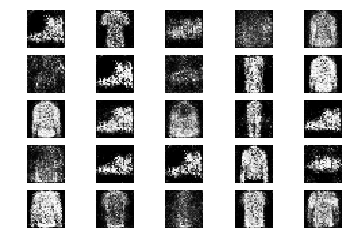

2601 [D loss: 0.644966, acc.: 60.94%] [G loss: 0.919680]
2602 [D loss: 0.575156, acc.: 71.88%] [G loss: 0.898286]
2603 [D loss: 0.667301, acc.: 57.81%] [G loss: 0.835172]
2604 [D loss: 0.687838, acc.: 51.56%] [G loss: 0.853453]
2605 [D loss: 0.621050, acc.: 71.88%] [G loss: 0.891801]
2606 [D loss: 0.592558, acc.: 67.19%] [G loss: 0.833262]
2607 [D loss: 0.644869, acc.: 64.06%] [G loss: 0.884749]
2608 [D loss: 0.690027, acc.: 59.38%] [G loss: 0.914297]
2609 [D loss: 0.592714, acc.: 73.44%] [G loss: 0.909341]
2610 [D loss: 0.569378, acc.: 67.19%] [G loss: 0.987111]
2611 [D loss: 0.643936, acc.: 65.62%] [G loss: 0.843795]
2612 [D loss: 0.635838, acc.: 64.06%] [G loss: 0.843402]
2613 [D loss: 0.635284, acc.: 54.69%] [G loss: 0.925680]
2614 [D loss: 0.674596, acc.: 60.94%] [G loss: 0.899177]
2615 [D loss: 0.645442, acc.: 57.81%] [G loss: 0.791166]
2616 [D loss: 0.662260, acc.: 60.94%] [G loss: 0.931093]
2617 [D loss: 0.607934, acc.: 67.19%] [G loss: 0.857876]
2618 [D loss: 0.675221, acc.: 5

2747 [D loss: 0.694442, acc.: 53.12%] [G loss: 0.926290]
2748 [D loss: 0.673308, acc.: 64.06%] [G loss: 0.943880]
2749 [D loss: 0.626659, acc.: 64.06%] [G loss: 1.055202]
2750 [D loss: 0.633741, acc.: 59.38%] [G loss: 1.030886]
2751 [D loss: 0.639940, acc.: 59.38%] [G loss: 0.955583]
2752 [D loss: 0.603020, acc.: 71.88%] [G loss: 0.955996]
2753 [D loss: 0.660203, acc.: 57.81%] [G loss: 0.847770]
2754 [D loss: 0.645329, acc.: 56.25%] [G loss: 0.893600]
2755 [D loss: 0.625729, acc.: 65.62%] [G loss: 0.942169]
2756 [D loss: 0.602736, acc.: 65.62%] [G loss: 1.029382]
2757 [D loss: 0.610859, acc.: 70.31%] [G loss: 0.909237]
2758 [D loss: 0.636423, acc.: 62.50%] [G loss: 0.838985]
2759 [D loss: 0.621590, acc.: 71.88%] [G loss: 0.879439]
2760 [D loss: 0.652661, acc.: 62.50%] [G loss: 0.996794]
2761 [D loss: 0.668372, acc.: 56.25%] [G loss: 0.813667]
2762 [D loss: 0.684432, acc.: 53.12%] [G loss: 0.895860]
2763 [D loss: 0.649063, acc.: 57.81%] [G loss: 0.896201]
2764 [D loss: 0.630263, acc.: 5

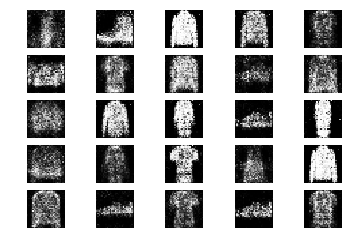

2801 [D loss: 0.619562, acc.: 71.88%] [G loss: 0.909283]
2802 [D loss: 0.646383, acc.: 60.94%] [G loss: 0.957870]
2803 [D loss: 0.594708, acc.: 75.00%] [G loss: 0.943607]
2804 [D loss: 0.619603, acc.: 68.75%] [G loss: 0.905223]
2805 [D loss: 0.610398, acc.: 67.19%] [G loss: 0.928101]
2806 [D loss: 0.635584, acc.: 59.38%] [G loss: 0.930634]
2807 [D loss: 0.623552, acc.: 64.06%] [G loss: 0.947279]
2808 [D loss: 0.638192, acc.: 62.50%] [G loss: 0.855129]
2809 [D loss: 0.582100, acc.: 75.00%] [G loss: 0.847809]
2810 [D loss: 0.717078, acc.: 56.25%] [G loss: 0.843470]
2811 [D loss: 0.620761, acc.: 62.50%] [G loss: 0.895498]
2812 [D loss: 0.555303, acc.: 73.44%] [G loss: 0.933237]
2813 [D loss: 0.643227, acc.: 67.19%] [G loss: 0.908833]
2814 [D loss: 0.671071, acc.: 60.94%] [G loss: 0.883304]
2815 [D loss: 0.654047, acc.: 54.69%] [G loss: 0.846890]
2816 [D loss: 0.579986, acc.: 67.19%] [G loss: 0.967957]
2817 [D loss: 0.626823, acc.: 62.50%] [G loss: 0.949997]
2818 [D loss: 0.672434, acc.: 5

2948 [D loss: 0.614899, acc.: 67.19%] [G loss: 0.901505]
2949 [D loss: 0.715655, acc.: 42.19%] [G loss: 0.929712]
2950 [D loss: 0.632477, acc.: 64.06%] [G loss: 0.951351]
2951 [D loss: 0.691582, acc.: 54.69%] [G loss: 1.034858]
2952 [D loss: 0.633229, acc.: 68.75%] [G loss: 0.924654]
2953 [D loss: 0.645630, acc.: 59.38%] [G loss: 0.930580]
2954 [D loss: 0.632509, acc.: 70.31%] [G loss: 0.945023]
2955 [D loss: 0.633120, acc.: 67.19%] [G loss: 0.976218]
2956 [D loss: 0.597882, acc.: 68.75%] [G loss: 0.911701]
2957 [D loss: 0.613039, acc.: 65.62%] [G loss: 0.984146]
2958 [D loss: 0.639799, acc.: 65.62%] [G loss: 0.980646]
2959 [D loss: 0.647372, acc.: 64.06%] [G loss: 0.950809]
2960 [D loss: 0.648821, acc.: 60.94%] [G loss: 0.883584]
2961 [D loss: 0.614474, acc.: 62.50%] [G loss: 0.925526]
2962 [D loss: 0.627438, acc.: 60.94%] [G loss: 0.889799]
2963 [D loss: 0.672519, acc.: 62.50%] [G loss: 0.892071]
2964 [D loss: 0.624606, acc.: 65.62%] [G loss: 0.847980]
2965 [D loss: 0.620341, acc.: 6

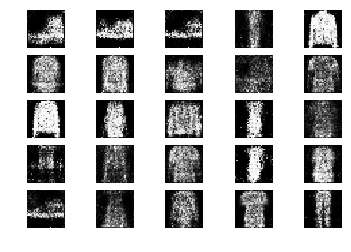

In [7]:

if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=3001, batch_size=32, sample_interval=200)